In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import numpy as np
import os
import collections
from json import loads
from six import iteritems

In [2]:
def deep_update(cfg, cfg_path):
    for k, v in iteritems(cfg_path):
        cfg[k] = (
                deep_update(cfg.get(k, {}), v)
                if isinstance(v, collections.Mapping) else
                v
            )
    return cfg


In [3]:
def GetSegments(cfg):
    Segments = []
    seg = []
    for key in cfg['racks'].keys():
        if(len(seg)==0):
            seg.append(1)
            seg.append(list(cfg['racks'][key].values())[1])
            seg.append(list(cfg['racks'][key].values())[0])
        elif(seg[-1]==list(cfg['racks'][key].values())[0] and seg[-2]==list(cfg['racks'][key].values())[1]):
            seg[0]+=1
        elif(seg[-1]!=list(cfg['racks'][key].values())[0] or seg[-2]!=list(cfg['racks'][key].values())[1]):
            Segments.append(seg.copy())
            seg[0]=1
            seg[1]=list(cfg['racks'][key].values())[1]
            seg[2]=list(cfg['racks'][key].values())[0]

        #print(seg)
    Segments.append(seg.copy())        
    print(Segments)
    return Segments

        

### Задать параметры

In [4]:
# hardcoded
#/home/vytautas/work/px4/catkin_ws/src/fs/cell_state_reader/config/warehouse_config.json
                                             #CHANGE ME !!
list_of_barcodes = []
list_of_coords = []
list_of_pairs = []

bar_files_list = sorted(os.listdir("../data/barcodes/tests/"))
coord_files_list = sorted(os.listdir("../data/coords/tests/"))
cfg = {}
deep_update(cfg, loads(open("../config/warehouse_config.json").read()))
#print(cfg)
Segments = GetSegments(cfg)

                    ###WAREHOUSE PARAMETERS
#Segments = [[12,3,[0,1,4,6,8,10,12.5]],[1,4,[0,4.5,8,10,12.5]],[12,3,[0,1,4,6,8,10,12.5]]]
#Segments = [[1,3,[0,1,4,6,8,10,12.5]],[1,1,[0,4.5,8,10,12.5]],[1,1,[0,1,4,6,8,10,12.5]]] #For local tests
segments_borders_list = [x[0]*x[1] for x in Segments]  #list of borders between segments
#print(segments_borders_list)

[[12, 3, [2, 4, 6, 8, 10, 11.5]], [1, 4, [4, 8, 10, 11.5]], [12, 3, [2, 4, 6, 8, 10, 11.5]]]


### Функция для парсинга файла с баркодами

In [5]:
def parse_barcodes(barcodes_file):
    barcodes_list = []   
    for line in barcodes_file:
        line= [element.rstrip() for element in line.split(' ') if element!="\n"]
        #line.remove("-") 
        barcodes_list.append(line)
    #print("       barcodes")
    #print(" start  end   barcode")
    #pprint.pprint(barcodes_list)
    barcodes_file.close()
    return barcodes_list


### Функция для парсинга файла с координатами клеток 

In [6]:
def parse_coords(coordinate_file):
    coords_list = []  
    for line in coordinate_file:
        coord_line = []
        line= [element.rstrip() for element in line.split(' ') if element!="\n"] # removing \n
        for element in line:
            element = element.replace(',','').split(' ') # removing ','
            coord_line.append(element[0])
        coords_list.append(coord_line)

    #print("         coords")
    #print("start end rack column level")
    #pprint.pprint(coords_list)
    coordinate_file.close()
    return coords_list

### Функция для получения координат паллеты по таймкоду

In [7]:
#A function that returns the coordinates of the cell depending on the time
def GetCoordFromTime(first_time, second_time, coords_list):
    #print("GET COORDS_LIST!!!")
    #print(coords_list)
    mean_time = (float(first_time)+float(second_time))/2          #This method is too simplistic.
    for cell in coords_list:
        if ((float(cell[0]) < mean_time) and (mean_time < float(cell[1]))):
            #print("cell 0 mean cell 1")
            #print(cell[0],  mean_time, cell[1])
            #print("cell2:")
            #print(cell[2::])
            return cell[2::]           
#I should change this func

### Функция для сопостовления времени когда были задетектированы баркоды с временем пролета рядом с ячейкой

In [8]:
def find_pair(barcodes_list, coords_list):
    coords_and_barcodes = []
    for line in barcodes_list:
        cell = GetCoordFromTime(line[0],line[1],coords_list) #GetCoordFromTime - return pallete coordinates depending on time
        #print("cell:")
        #print(cell)
        if(cell is not None):
            cell.append(line[-1])
            coords_and_barcodes.append(cell)
    return coords_and_barcodes

### Функция для получения номеров секций

In [9]:
def find_column_nums(coords_list):
    column_list = set()
    for line in coords_list:
        column_list.add(line[2])
    #print(columns_list)
    return column_list

### Функция для сегментирования

In [10]:
def find_segments_params(list_of_pairs):
    current_segment = 0
    border = segments_borders_list[current_segment]
    barcodes_in_segment = [[] for x in range(len(Segments))]
    for pairs in list_of_pairs:
        for element in pairs:
            #print("ELEMENT AND BORDER!!!")
            #print(float(element[1]),border)
            if (float(element[1])<border):
                barcodes_in_segment[current_segment].append(element)
            else:
                #print("OLD border")
                #print(border)
                current_segment +=1
                #print("current sgement")
                #print(current_segment)
                border = (border + segments_borders_list[current_segment])# if current_segment<len(segments_borders_list) else (border+1)
                #print("NEW border")
                #print(border)
                barcodes_in_segment[current_segment].append(element)
    #print("barcodes_in_segment")
    #print(barcodes_in_segment)
    return barcodes_in_segment
        
    

### Функция для составления таблицы заполненности ячеек

In [11]:
def cell_occupancy(segment,current_segment):
    curr_segment_levels = Segments[current_segment][2]
    curr_segment_border = segments_borders_list[current_segment] #!!!!!
    result = np.zeros((len(curr_segment_levels)-1,curr_segment_border), int)
    #result = np.zeros((len(curr_segment_levels),curr_segment_border), int)
    #print(result)
    start_num_index = int(segment[0][2])
    start_num_column = int(segment[0][1])
    #print(start_num_index)
    for line in segment:
        #print((int(line[2]),int(line[1])))
        result[(int(line[2]) - start_num_index,int(line[1])-start_num_column)] =line[3]
    result = np.flip(result,0)
    #print(result)

    index_ =  ["   "+(str(x)) for x in range(len(curr_segment_levels)-1)]
    columns_ =["   "+(str(x)) for x in range(curr_segment_border)]
    index_.reverse()
    DF = pd.DataFrame(result,index = index_,columns=columns_)
    DF.index.names = ['levels']
    DF.columns.names = ['sections']
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', 15)
    pd.set_option('display.width', 5000)
    pprint.pprint(DF)
    visualize_cells(DF,index_,columns_)

### Функция для визуализации таблицы

In [12]:
def visualize_cells(DF,index_,columns_):
    # (c) https://stackoverflow.com/questions/3529666/matplotlib-matshow-labels
    # kwargs for matshow and imshow func - https://matplotlib.org/2.1.0/api/_as_gen/matplotlib.pyplot.imshow.html
    from matplotlib.colors import ListedColormap

    fig = plt.figure() #figsize=(6, 12)
    ax = fig.add_subplot(111)
    cmap = ListedColormap(['r', 'g', 'g'])

    cax = ax.matshow(DF, cmap=cmap, vmin = -8)
    #fig.colorbar(cax)
    ax.set_xticklabels(['']+columns_)
    ax.set_yticklabels(['']+index_)
    plt.show()
    #Надо обязательно решить вопрос как визуализировать все ячейки, 
    #как я понял функция matshow показывает только самые больше значения
    #чтобы понять можно поиграть с параметтром vmin

# Основная часть !

SEGMENT № 0
sections     0     1     2     3     4     5     6  ...     29     30     31     32     33     34     35
levels                                              ...                                                 
   4         6     7    18     0     0     0     0  ...      0      0      0      0      0      0      0
   3         5     8     0     0    28     0     0  ...      0      0      0      0      0      0      0
   2         4     9     0    19    26     0     0  ...      0      0      0      0      0      0      0
   1         3    10    15    20    25     0     0  ...      0      0      0      0      0      0      0
   0         2    11    14    21    24     0     0  ...      0      0      0      0      0      0      0

[5 rows x 36 columns]


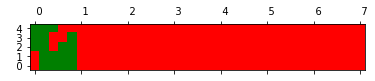

In [13]:
for file in bar_files_list: #Парсим все файлы в папке с баркодами
    list_of_barcodes.append(parse_barcodes(open("../data/barcodes/tests/"+str(file))))
    
    
for file in coord_files_list: #Парсим все файлы в папке с координатами паллет
    list_of_coords.append(parse_coords(open("../data/coords/tests/"+str(file))))

    
for bar,coord in zip(list_of_barcodes,list_of_coords):   #Находим пары координаты места - баркод
    list_of_pairs.append(find_pair(bar,coord))
#print(list_of_pairs)
    
# разделяем все пары координаты + баркод на сегменты
barcodes_in_segment = find_segments_params(list_of_pairs)
i = 0
for segment in barcodes_in_segment:
    if(len(segment)>0):
        print("SEGMENT № {}".format(i))
        #print(segment)
        cell_occupancy(segment,i)
    i+=1

In [45]:
# Создаем гиперссылку на баркод который был замечен (для него нашлась пара)
""" result = np.zeros((warehouse_max_level_num, warehouse_max_column_num), list)
#for line in coords_and_barcodes:
    if len(line)>0:
        url = 'photos/fast-sense-x.JPG' # Изменить адресс для каждого баркода
        name = line[3]
        result[(int(line[2]),int(line[1]))] = '<a href="{}">{}</a>'.format(url,name)

# Создаем гиперссылку для ячейки в которой не был задетектирован баркод
url = 'photos/fast-sense-x.JPG'
name = "NO!"
for x in result:        
    zero_indexs = np.nonzero(x==0)[0]
    for index in zero_indexs:
        x[index] = '<a href="{}">{}</a>'.format(url,name)

index_ =  ["   "+(str(x)) for x in range(warehouse_max_level_num+1)][1:]
columns_ =["   "+(str(x)) for x in range(warehouse_max_column_num+1)][1:]
DF = pd.DataFrame(result,index = index_,columns=columns_)
DF.index.names = ['levels']
DF.columns.names = ['columns']

# Оторажаем
DF.style 
"""

' result = np.zeros((warehouse_max_level_num, warehouse_max_column_num), list)\n#for line in coords_and_barcodes:\n    if len(line)>0:\n        url = \'photos/fast-sense-x.JPG\' # Изменить адресс для каждого баркода\n        name = line[3]\n        result[(int(line[2]),int(line[1]))] = \'<a href="{}">{}</a>\'.format(url,name)\n\n# Создаем гиперссылку для ячейки в которой не был задетектирован баркод\nurl = \'photos/fast-sense-x.JPG\'\nname = "NO!"\nfor x in result:        \n    zero_indexs = np.nonzero(x==0)[0]\n    for index in zero_indexs:\n        x[index] = \'<a href="{}">{}</a>\'.format(url,name)\n\nindex_ =  ["   "+(str(x)) for x in range(warehouse_max_level_num+1)][1:]\ncolumns_ =["   "+(str(x)) for x in range(warehouse_max_column_num+1)][1:]\nDF = pd.DataFrame(result,index = index_,columns=columns_)\nDF.index.names = [\'levels\']\nDF.columns.names = [\'columns\']\n\n# Оторажаем\nDF.style \n'